             Date Time  Order Number         Activity       Server
0  2024-05-26 16:02:00             0           Seated  Waitstaff A
1  2024-05-26 16:04:00             0      Visit Table  Waitstaff A
2  2024-05-26 16:07:00             0     Order Posted  Waitstaff A
3  2024-05-26 16:17:00             0  Order Delivered  Waitstaff A
4  2024-05-26 16:18:00             0   Bill Delivered  Waitstaff A
5  2024-05-26 16:20:00             0        Bill Paid  Waitstaff A
6  2024-05-26 16:22:00             1           Seated  Waitstaff A
7  2024-05-26 16:27:00             1      Visit Table  Waitstaff A
8  2024-05-26 16:29:00             1     Order Posted  Waitstaff A
9  2024-05-26 16:38:00             1  Order Delivered  Waitstaff A
10 2024-05-26 16:39:00             1   Bill Delivered  Waitstaff A
11 2024-05-26 16:42:00             1        Bill Paid  Waitstaff A
12 2024-05-26 16:45:00             2           Seated  Waitstaff A
13 2024-05-26 16:47:00             2      Visit Table  Waitsta

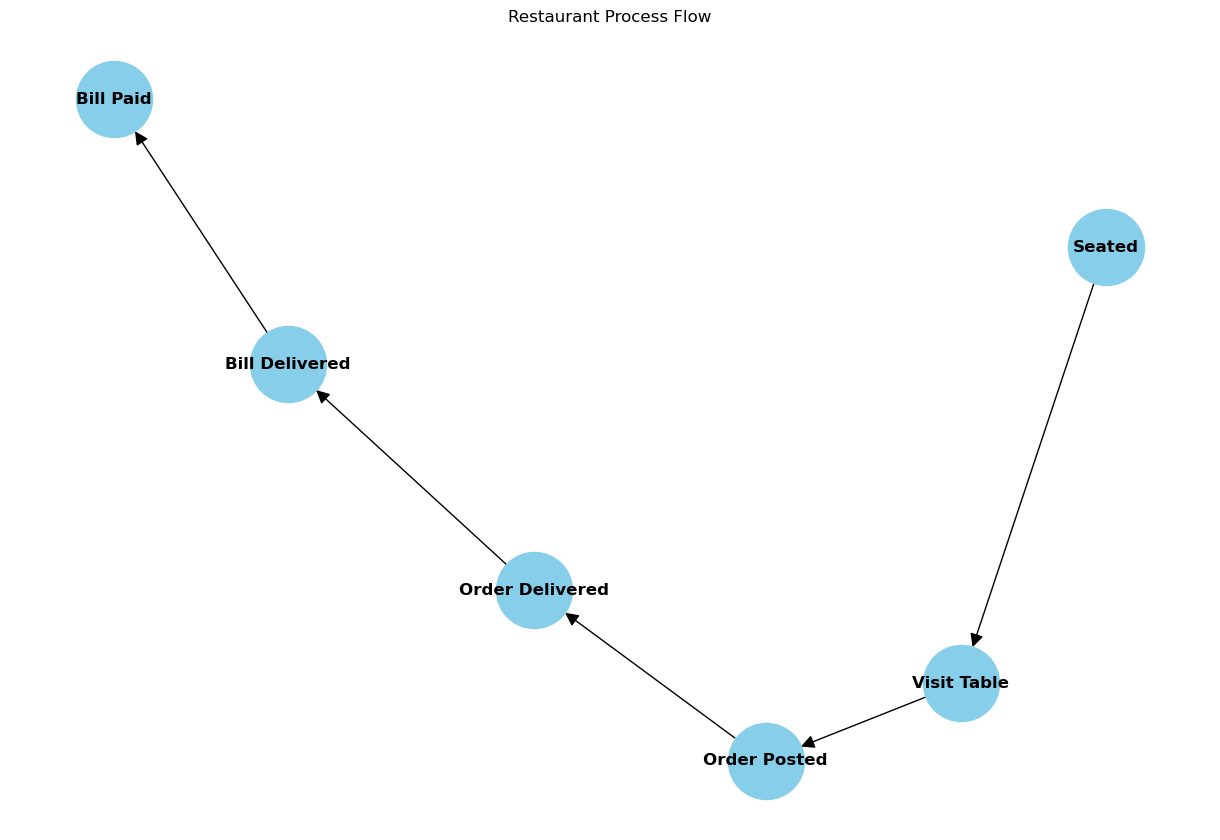

In [8]:
import simpy
import random
import pandas as pd
from datetime import datetime, timedelta
import networkx as nx
import matplotlib.pyplot as plt

# Initialize the environment
env = simpy.Environment()

# Define the restaurant process
class Restaurant:
    def __init__(self, env):
        self.env = env
        self.waitstaff_A = simpy.Resource(env, capacity=1)
        self.waitstaff_B = simpy.Resource(env, capacity=1)
        self.log = []

    def seat_guest(self, order_number, server):
        yield self.env.timeout(random.randint(1, 3))
        self.log.append([self.env.now, order_number, 'Seated', server])

    def visit_table(self, order_number, server):
        yield self.env.timeout(random.randint(2, 5))
        self.log.append([self.env.now, order_number, 'Visit Table', server])

    def post_order(self, order_number, server):
        yield self.env.timeout(random.randint(1, 3))
        self.log.append([self.env.now, order_number, 'Order Posted', server])

    def deliver_order(self, order_number, server):
        yield self.env.timeout(random.randint(5, 10))
        self.log.append([self.env.now, order_number, 'Order Delivered', server])

    def deliver_bill(self, order_number, server):
        yield self.env.timeout(random.randint(1, 2))
        self.log.append([self.env.now, order_number, 'Bill Delivered', server])

    def pay_bill(self, order_number, server):
        yield self.env.timeout(random.randint(1, 3))
        self.log.append([self.env.now, order_number, 'Bill Paid', server])

    def process_order(self, order_number):
        with self.waitstaff_A.request() as request:
            yield request
            yield self.env.process(self.seat_guest(order_number, 'Waitstaff A'))
            yield self.env.process(self.visit_table(order_number, 'Waitstaff A'))
            yield self.env.process(self.post_order(order_number, 'Waitstaff A'))
            yield self.env.process(self.deliver_order(order_number, 'Waitstaff A'))
            yield self.env.process(self.deliver_bill(order_number, 'Waitstaff A'))
            yield self.env.process(self.pay_bill(order_number, 'Waitstaff A'))

def run_simulation():
    restaurant = Restaurant(env)
    for i in range(10):  # Simulate 10 orders
        env.process(restaurant.process_order(i))
    env.run(until=100)

    # Convert log to DataFrame and format timestamps
    df = pd.DataFrame(restaurant.log, columns=['Time', 'Order Number', 'Activity', 'Server'])
    start_time = datetime(2024, 5, 26, 16, 0)
    df['Date Time'] = df['Time'].apply(lambda x: start_time + timedelta(minutes=x))
    df = df[['Date Time', 'Order Number', 'Activity', 'Server']]

    return df

def create_process_graph(df):
    G = nx.DiGraph()
    
    # Add nodes and edges based on the activities
    activities = df['Activity'].unique()
    for i in range(len(activities) - 1):
        G.add_edge(activities[i], activities[i + 1])
    
    # Draw the graph
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=12, font_weight="bold", arrowsize=20)
    plt.title("Restaurant Process Flow")
    plt.show()

# Run the simulation and create the process graph
df_log = run_simulation()
print(df_log)
create_process_graph(df_log)